In [4]:
import pymongo, os, re, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict, defaultdict
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import nltk
from com.ibm.watson.datasource.clinicaltrials import ClinicalTrials, ClinicalStudy

In [5]:
DESKTOP = os.path.join(os.environ["HOME"], "Desktop")
DOCUMENTS = os.path.join(os.environ["HOME"], "Documents")

In [6]:
client = pymongo.MongoClient('localhost', 27017)
db = client["WATSON"]

In [19]:
trials_features = []
all_diseases = []
all_interventions = []
all_phases = []
all_statuses = []
for study in db["CTGOV"].find({"metadata.STATUS" : "ACCEPTED"}):
    all_diseases.extend( [x["ID"] for x in study["conditions"] if "ID" in x] )
    all_interventions.extend( [x["ID"] for x in study["interventions"] if "ID" in x] )
    all_phases.append("/".join(study["PHASES"]))
    all_statuses.append(study["STATUS"])
    
all_diseases = set(all_diseases)
all_interventions = set(all_interventions)
all_phases = set(all_phases)
all_statuses = set(all_statuses)

print "All diseases: %d" % len(all_diseases)
print "All interventions: %d" % len(all_interventions)
print "All phases: %d" % len(all_phases)
print "All statuses: %d" % len(all_statuses)

All diseases: 1113
All interventions: 343
All phases: 7
All statuses: 8


In [4]:
print all_phases
print all_statuses

set(['', u'1/2', u'1', u'0', u'3', u'2', u'4', u'2/3'])
set([u'Terminated', u'Completed', u'Recruiting', u'Not yet recruiting', u'Suspended', u'Enrolling by invitation', u'Withdrawn', u'Active, not recruiting'])


In [20]:
all_diseases = list(all_diseases)
all_interventions = list(all_interventions)
all_phases = list(all_phases)
all_statuses = list(all_statuses)

#feature_length = (1 + 1 + len(all_diseases) + len(all_interventions))
features_matrix = []
feature_length = len(all_diseases)
for study in db["CTGOV"].find({"metadata.STATUS" : "ACCEPTED"}):
    study_condition_cuis = [x["ID"] for x in study["conditions"] if "ID" in x]
    features = [ int(x in study_condition_cuis) for x in all_diseases ]
    features_matrix.append(features)
    
#features_matrix = csr_matrix(features_matrix)

In [21]:
print features_matrix.ndim
print features_matrix.shape

AttributeError: 'list' object has no attribute 'ndim'

In [8]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(features_matrix)

In [10]:
print kmeans.labels_
print kmeans.cluster_centers_

[2 2 2 ..., 2 2 2]
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.00067329  0.00050497  0.00016832 ...,  0.00100993  0.00016832
   0.00016832]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(features_matrix)

In [23]:
print X.shape
print X[0]

(1600, 2)
[-0.19403169  0.27565513]


In [24]:
kmeans1 = KMeans(n_clusters = 8, random_state = 0)
predictions = kmeans1.fit_predict(X)
print predictions.shape

(1600,)


In [28]:
predictions_dict = zip( predictions, [x["NCT_ID"] for x in db["CTGOV"].find({"metadata.STATUS" : "ACCEPTED"})] )
from collections import defaultdict
d = defaultdict(list)
for k, v in predictions_dict:
    d[k].append(v)
    
for k, v in d.iteritems():
    print "%d: (%d)" % (k, len(v))

0: (1142)
1: (14)
2: (31)
3: (52)
4: (58)
5: (18)
6: (20)
7: (265)


In [29]:
print d[1]

[u'NCT01744223', u'NCT01665768', u'NCT01755975', u'NCT01992653', u'NCT01638533', u'NCT01745354', u'NCT01636622', u'NCT00576654', u'NCT01805037', u'NCT02278250', u'NCT02341014', u'NCT00345865', u'NCT01576406', u'NCT01744652']


In [34]:
for study in db["CTGOV"].find({"NCT_ID" : {"$in" : d[0]} }):
    print "%s: (%d)" % (study["NCT_ID"], len(study["conditions"]))

NCT00001379: (8)
NCT00006436: (5)
NCT00054496: (1)
NCT00075387: (10)
NCT00085735: (0)
NCT00096161: (0)
NCT00107289: (2)
NCT00177047: (4)
NCT00206518: (3)
NCT00293475: (3)
NCT00303849: (3)
NCT00316888: (1)
NCT00321555: (1)
NCT00336024: (0)
NCT00338377: (1)
NCT00345345: (1)
NCT00363649: (2)
NCT00411788: (1)
NCT00412594: (4)
NCT00430183: (5)
NCT00432094: (54)
NCT00450814: (2)
NCT00466531: (1)
NCT00490529: (1)
NCT00492778: (4)
NCT00515411: (9)
NCT00549848: (1)
NCT00554788: (0)
NCT00565708: (12)
NCT00565851: (10)
NCT00573989: (1)
NCT00626990: (0)
NCT00632853: (1)
NCT00653068: (0)
NCT00669669: (3)
NCT00686556: (9)
NCT00703820: (11)
NCT00707473: (3)
NCT00733408: (0)
NCT00774345: (0)
NCT00777244: (3)
NCT00788164: (3)
NCT00790842: (0)
NCT00807599: (0)
NCT00812240: (1)
NCT00814073: (3)
NCT00823459: (0)
NCT00828009: (1)
NCT00840177: (6)
NCT00843882: (3)
NCT00859781: (5)
NCT00860171: (6)
NCT00879437: (0)
NCT00887146: (3)
NCT00888615: (10)
NCT00903968: (0)
NCT00910650: (3)
NCT00921115: (1)
NCT00923

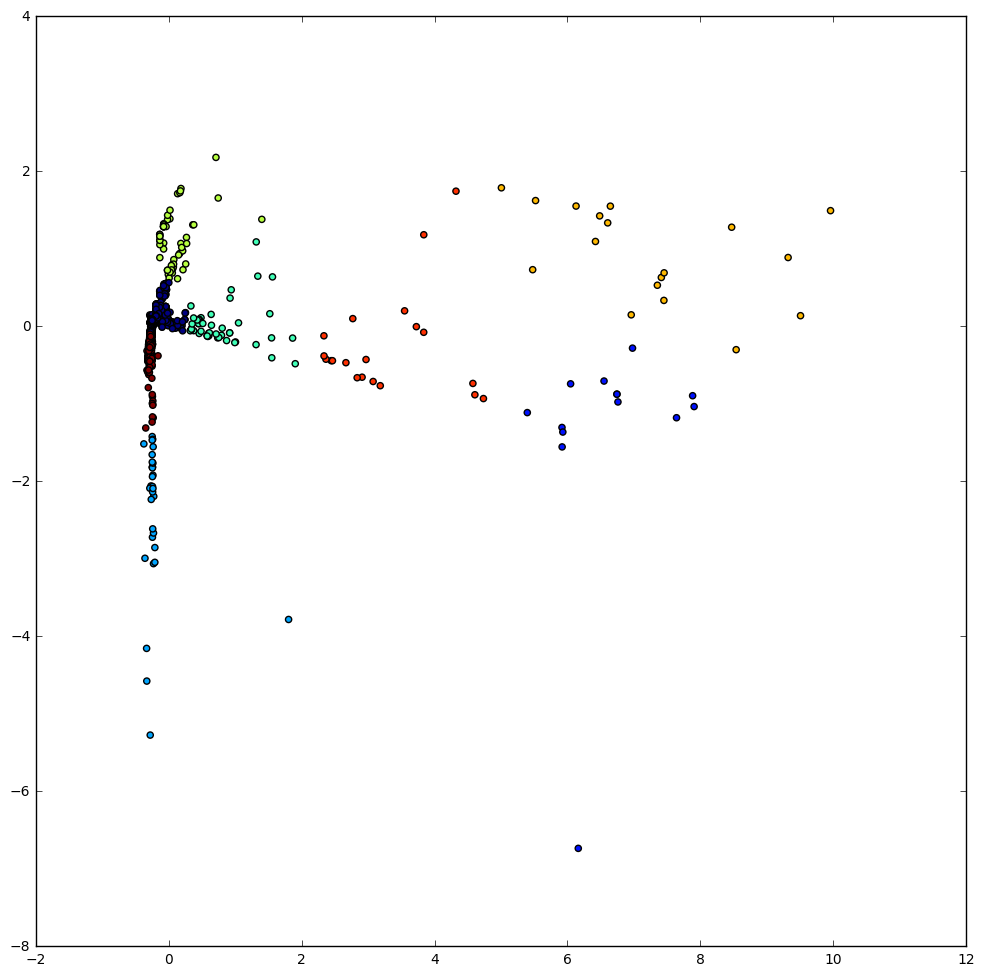

In [25]:
plt.figure(figsize=(12,12))
plt.scatter(X[:,0], X[:,1], c=predictions)
plt.show()